In [146]:
%pylab inline
from IPython.display import Image
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import KFold
from sklearn.svm import LinearSVC
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.signal import fftconvolve
from PIL import Image
import scipy.ndimage

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
#Load the data
X_train = np.load('dataset/data_and_scripts/train_inputs.npy')
y_train = np.load('dataset/data_and_scripts/train_outputs.npy')
X_test = np.load('dataset/data_and_scripts/test_inputs.npy')
print("Size of the train dataset: {}".format(X_train.shape))
print("Size of the test dataset: {}".format(X_test.shape))

Size of the train dataset: (50000, 2304)
Size of the test dataset: (20000, 2304)


In [4]:
#reshape image data
im = X_train[0]
print("original dimensions: {}".format(im.shape))

im2 = np.reshape(im,(48,48))

print("new dimensions: {}".format(im2.shape))

original dimensions: (2304,)
new dimensions: (48, 48)


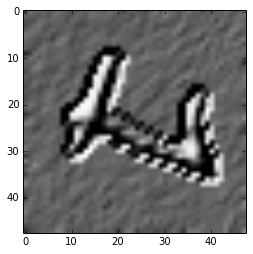

In [5]:
#display image
imshow(im2,cmap = cm.Greys_r)

In [8]:
def getImage(example):
    im = np.reshape(example,(48,48))
    im = im*255
    im = Image.fromarray(im)
    return im

In [10]:
#make filters
def makeCross():
    icross = np.ones((48,48))
    icross[23,:] = 0
    icross[24,:] = 0
    icross[:,23] = 0
    icross[:,24] = 0
    return icross*255

def makeGrid():
    grid = 255*np.ones((48,48))
    for i in range(12):
        grid[:,4*i] = 0
        grid[4*i,:] = 0
    return grid

def makeGabor(kx,ky,mux,muy,sigx,sigy):
    cs = np.array(zeros((48,48)))
    gauss = np.array(zeros((48,48)))

    kx = 0
    ky = 1
    mux = 24
    muy = 24
    sigx = 1
    sigy = 1

    for i in range(48):
        for j in range(48):
            cs[i,j] = 255*(1-cos(kx*i + ky*j))
            gauss[i,j] = 255*(1-(1/(sigx*sigy*2*np.pi)*exp(-(i-mux)**2/(2*sigx**2)-(j-muy)**2/(2*sigy**2))))

    return np.dot(cs,gauss)

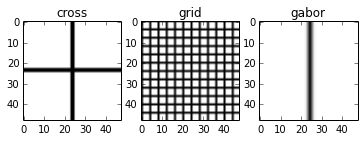

In [11]:
#display filters

figure()
subplot(1,3,1)
imshow(makeCross(),cmap = cm.Greys_r)
title('cross')
subplot(1,3,2)
imshow(makeGrid(),cmap = cm.Greys_r)
title('grid')
subplot(1,3,3)
imshow(makeGabor(0,1,24,24,1,1),cmap = cm.Greys_r)
title('gabor')

In [27]:
def rotation(image, steps):
    cr = makeGabor(0,2,24,24,1,1)
    maxconv = 0
    maxang = 0    
    
    for i in range(steps):
        ang = i*360/steps
        im = image.rotate(ang)
        con = fftconvolve(im, cr, mode='full')
        val = np.mean(con)
        
        if(val > maxconv):
            maxconv = val
            maxang = ang
        
    return image.rotate(maxang)

def threshold(image, thresh):
    image = 255/np.max(image)*image
    
    low = image < thresh
    high = image >= thresh
    image[low] = 0
    image[high] = 255
    return image

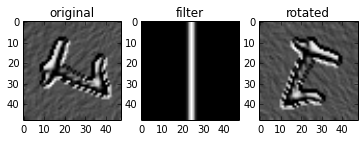

In [20]:
#example rotation
image = getImage(X_train[0])
new = rotation(image,360)

figure()
subplot(1,3,1)
imshow(image,cmap = cm.Greys_r)
title('original')
subplot(1,3,2)
imshow(255*(1-makeGabor(0,2,24,24,1,1)),cmap = cm.Greys_r)
title('filter')
subplot(1,3,3)
imshow(new,cmap = cm.Greys_r)
title('rotated')

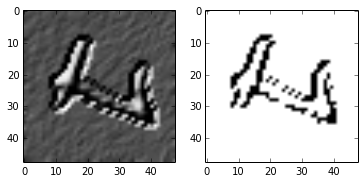

In [49]:
#example threshold
im = getImage(X_train[0])
figure()
subplot(1,2,1)
imshow(im,cmap = cm.Greys_r)

imthresh = threshold(im,1)    #1 works
subplot(1,2,2)
imshow(imthresh,cmap = cm.Greys_r)

In [276]:
def centerImage(image, method='com'):
    if(method=='bbox'):
        
        left = 0
        right = 47
        top = 0
        bottom = 47
        
        for i in range(48):
            if(left == 0 and np.min(image[:,i]) < 255):   #left edge found
                left = i
            if(right == 47 and np.min(image[:,47-i]) < 255):    #right edge found
                right = 47-i
            if(top == 0 and np.min(image[i,:]) < 255):   #left edge found
                top = i
            if(bottom == 47 and np.min(image[47-i,:]) < 255):    #right edge found
                bottom = 47-i

        #crop out excess
        newIm = image[top:bottom,left:right]

        #resize image to 48x48
        shape = newIm.shape
        scale = (48/shape[0],48/shape[1])
        newIm = scipy.ndimage.zoom(newIm, scale, order=2)

        #rescale values 0-255
        newIm = 255/np.max(newIm)*newIm
        newIm = threshold(newIm,20)
            
        return newIm
            
    elif(method=='com'):
        image = (1/255)*(255 - threshold(image,1))    #all points weighted equally

        #calculate center of mass
        xsum = 0
        ysum = 0
        count = 0
        for i in range(48):
            for j in range(48):
                if(image[i,j] > 0):
                    xsum+=i
                    ysum+=j
                    count+=1
        com = (xsum/count,ysum/count)
        
        #center about COM
        dx = np.floor(com[0]-23.5)
        dy = np.floor(com[1]-23.5)
    
        dx,dy
    
        #center about COM
        dx = np.floor(com[0]-23.5)
        dy = np.floor(com[1]-23.5)

        if(dx > 0):
            newIm = np.pad(image,((0,0),(dx,0)), mode='constant')[:, :-dx]
        else:
            newIm = np.pad(image,((0,0),(0,-dx)), mode='constant')[:, -dx: ]

        if(dy > 0):
            newIm = np.pad(image,((dy,0),(0,0)), mode='constant')[:-dy, :]
        else:
            newIm = np.pad(image,((0,-dy),(0,0)), mode='constant')[-dy:, : ]

        return 255*(1-newIm)
        
    else:
        print("invalid method: '{}'".format(method))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:66: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


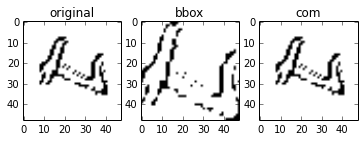

In [277]:
#compare centering techniques
image = getImage(X_train[0])
image = threshold(image,1)

figure()
subplot(1,3,1)
title('original')
imshow(image,cmap=cm.Greys_r)

subplot(1,3,2)
title('bbox')
im = centerImage(image,'bbox')
imshow(im,cmap=cm.Greys_r)

subplot(1,3,3)
title('com')
im = centerImage(image,'com')
imshow(im,cmap=cm.Greys_r)

In [ ]:
t0 = time()
pca = PCA(n_components='mle')
pca.fit(X_train)
n_components_pca_mle = pca.n_components_
print("Best n_components by PCA MLE = %d" % n_components_pca_mle)
print(pca.explained_variance_ratio_) 
print('Time : ' + "%.4f" % (time()-t0) + ' seconds') 

In [ ]:
t0 = time()
pca.set_params(n_components=pca.n_components_)
X_train_subset_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('Time : ' + "%.4f" % (time()-t0) + ' seconds') 

In [ ]:
#Configuration parameters
C = np.logspace(-2, 10, 13)
tuned_parameters = dict( C=C)
cv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.2, random_state=2015)

#Cross-validation
t0 = time()
grid = GridSearchCV(LogisticRegression(),param_grid=tuned_parameters, cv=cv)
grid.fit(X, y)
print(grid.best_estimator_)
print('Time : ' + "%.4f" % (time()-t0) + ' seconds') 
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() / 2, params))

In [ ]:
#Configuration parameters
C = np.logspace(-2, 10, 13)
tuned_parameters = dict( C=C)
cv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.2, random_state=2015)

#Cross-validation
t0 = time()
grid = GridSearchCV(LinearSVC(),param_grid=tuned_parameters, cv=cv)
grid.fit(X, y)
print(grid.best_estimator_)
print('Time : ' + "%.4f" % (time()-t0) + ' seconds') 

In [ ]:
#Train the classifier with the best C value
t0 = time()
clf = LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)
clf.fit(X_train,y_train)
print('Training time : ' + "%.4f" % (time()-t0) + ' seconds') 

In [ ]:
#Prediction
pred = clf.predict(X_test)
rows = [x for x in range(1,20001)]
prediction = pd.DataFrame(data=pred, index=rows)
prediction.to_csv('dataset/output/linearSVC.csv', sep=',', encoding='utf-8', index_label='Id', header=['Prediction'])